In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import seaborn as sns

/rhome/sawale/FunnyProject/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# df = pd.read_parquet("/Users/sawale/Documents/FunnyProject/data/labeled_jokes.parquet")
TARGET_COLUMNS = ['humor', 'offensiveness', 'sentiment']
def load_data(file_path, nrows=None):
    # Load dataset from a Parquet file
    df = pd.read_parquet(file_path)
    if nrows:
        df = df.head(nrows)
    
    # Cast the target columns to int for classification purposes.
    df[TARGET_COLUMNS] = df[TARGET_COLUMNS].astype(int)
    
    # Drop rows where any value in the target columns isn't 0 or 1.
    # This creates a boolean mask that checks for binary values.
    df = df[df[TARGET_COLUMNS].isin([0, 1]).all(axis=1)]
    
    # Ensure that the 'joke' column is of type string.
    df['joke'] = df['joke'].astype(str)

    
    return df

df = load_data("../data/labeled_jokes_classification_mistral:latest.parquet")
df.shape

(55552, 6)

In [4]:
df.head()

,date,joke,score,humor,offensiveness,sentiment
545408,2019-10-07 02:57:10,Anti-dandruff shampoo with sulfur causes hair ...,1.0,1,0,1
82671,2015-03-23 17:59:44,I use to be addicted to the Hokie Pokie.... bu...,3.0,1,0,1
158355,2016-03-24 13:09:05,A man goes into a job interview A man goes int...,11956.0,1,0,1
76515,2015-02-20 02:35:30,What is the one food that diminishes a woman's...,76.0,1,0,0
178322,2016-06-19 20:21:42,Rick Astley will let you borrow any movie from...,81.0,1,0,1


In [5]:
# shuffle the dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
df[df["offensiveness"] == 1]

,date,joke,score,humor,offensiveness,sentiment
3,2012-11-16 00:55:42,"Yep, it's a Yo-Mama joke Yo Mama'a so fat that...",0.0,0,1,1
5,2012-12-15 00:05:27,Yo mama jokes Yo mama so stupid that when saw ...,4.0,0,1,0
8,2011-11-15 05:29:21,I like my women like I like my onion rings. Ba...,7.0,0,1,1
17,2015-05-23 21:12:10,I met a girl with 12 nipples Which sounds funn...,1203.0,0,1,1
19,2015-05-17 14:28:55,A husband and wife are trying to set up a new ...,0.0,0,1,1
...,...,...,...,...,...,...
55531,2019-07-27 21:38:21,What do you call an Italian cannibal? Windego,2.0,0,1,1
55542,2016-06-16 04:24:03,What do you call a confederate that's bleeding...,104.0,0,1,1
55543,2019-07-19 20:03:34,I recently got a heart-transplant and I fear m...,2.0,0,1,1
55549,2019-09-17 08:02:39,"What is invisible, known to us through gravity...",0.0,0,1,1


# EDA on joke length

Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors


Five-Point Summary for Joke Token Counts:
min: 2
Q1: 17.0
median: 24.0
Q3: 45.0
max: 2845
Percentage of documents with token counts > 64: 19.39%
Token count at 99.9th percentile: 882.3470000000234


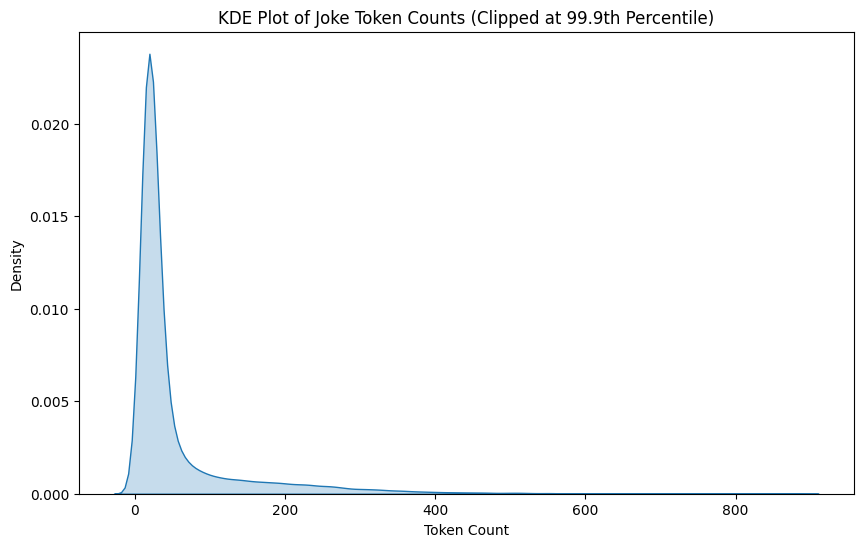

In [ ]:
# Step 1: Initialize the tokenizer from Hugging Face.
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilroberta-base")

# Step 2: Create a new column to count the tokens in each joke.
# Here, tokenizer.tokenize(x) returns a list of tokens, and we take its length.
df['joke_token_count'] = df['joke'].apply(lambda x: len(tokenizer.tokenize(x)))

# Step 3: Compute the five-number summary for token counts.
five_point_summary = {
    'min': df['joke_token_count'].min(),
    'Q1': df['joke_token_count'].quantile(0.25),
    'median': df['joke_token_count'].median(),
    'Q3': df['joke_token_count'].quantile(0.75),
    'max': df['joke_token_count'].max()
}

print("Five-Point Summary for Joke Token Counts:")
for key, value in five_point_summary.items():
    print(f"{key}: {value}")

# Step 4: Calculate the percentage of documents with token count greater than 512.
docs_over_512 = (df['joke_token_count'] > 128).sum()
total_docs = len(df)
percentage_over_512 = (docs_over_512 / total_docs) * 100
print(f"Percentage of documents with token counts > 128: {percentage_over_512:.2f}%")

# Step 5: Determine the clip value: the 99.9th percentile of the token counts.
clip_value = df['joke_token_count'].quantile(0.999)
print(f"Token count at 99.9th percentile: {clip_value}")

# Step 6: Plot the KDE (Kernel Density Estimate) of the token count distribution.
# We filter the data to include only those documents with token counts less than or equal to clip_value.
plt.figure(figsize=(10, 6))
filtered_data = df[df['joke_token_count'] <= clip_value]
sns.kdeplot(data=filtered_data, x='joke_token_count', fill=True)
plt.title("KDE Plot of Joke Token Counts (Clipped at 99.9th Percentile)")
plt.xlabel("Token Count")
plt.ylabel("Density")
plt.show()

# Analysis on target columns

Distribution for humor:
       Count  Percentage (%)
humor                       
0      17252           31.06
1      38300           68.94


Distribution for offensiveness:
               Count  Percentage (%)
offensiveness                       
0              41441            74.6
1              14111            25.4


Distribution for sentiment:
           Count  Percentage (%)
sentiment                       
0           8235           14.82
1          47317           85.18




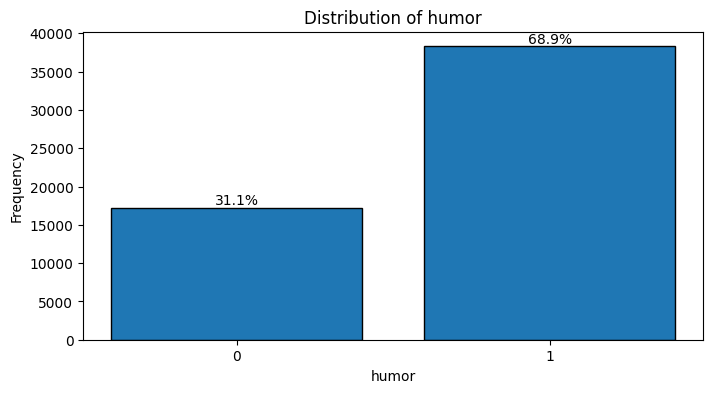

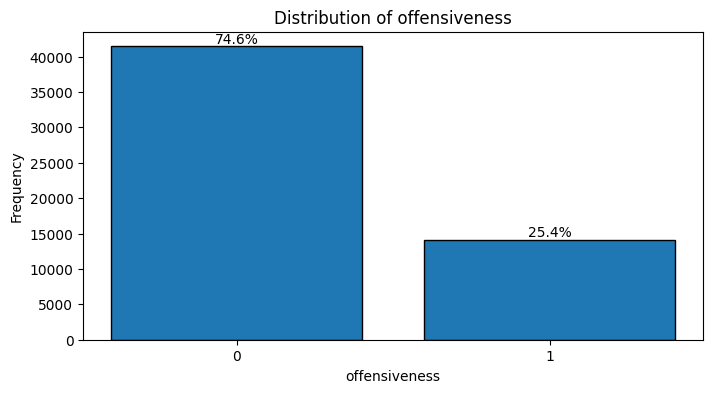

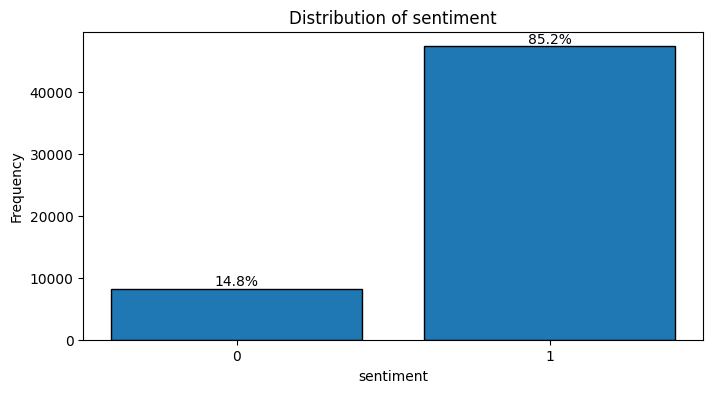

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is already loaded as 'df'
discrete_cols = ['humor', 'offensiveness', 'sentiment']

# 1. For each discrete column, print frequency counts and percentages.
for col in discrete_cols:
    print(f"Distribution for {col}:")
    counts = df[col].value_counts().sort_index()
    percentages = (counts / counts.sum() * 100).round(2)
    summary_df = pd.DataFrame({'Count': counts, 'Percentage (%)': percentages})
    print(summary_df)
    print("\n")

# 2. Plot the distribution for each discrete column using bar charts.
for col in discrete_cols:
    counts = df[col].value_counts().sort_index()
    plt.figure(figsize=(8, 4))
    plt.bar(counts.index.astype(str), counts.values, edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    # Optionally, add the percentage on top of each bar for clarity.
    for index, value in counts.items():
        plt.text(x=str(index), y=value, s=f"{(value / counts.sum() * 100):.1f}%", ha='center', va='bottom')
    plt.show()


# Chroma Analysis

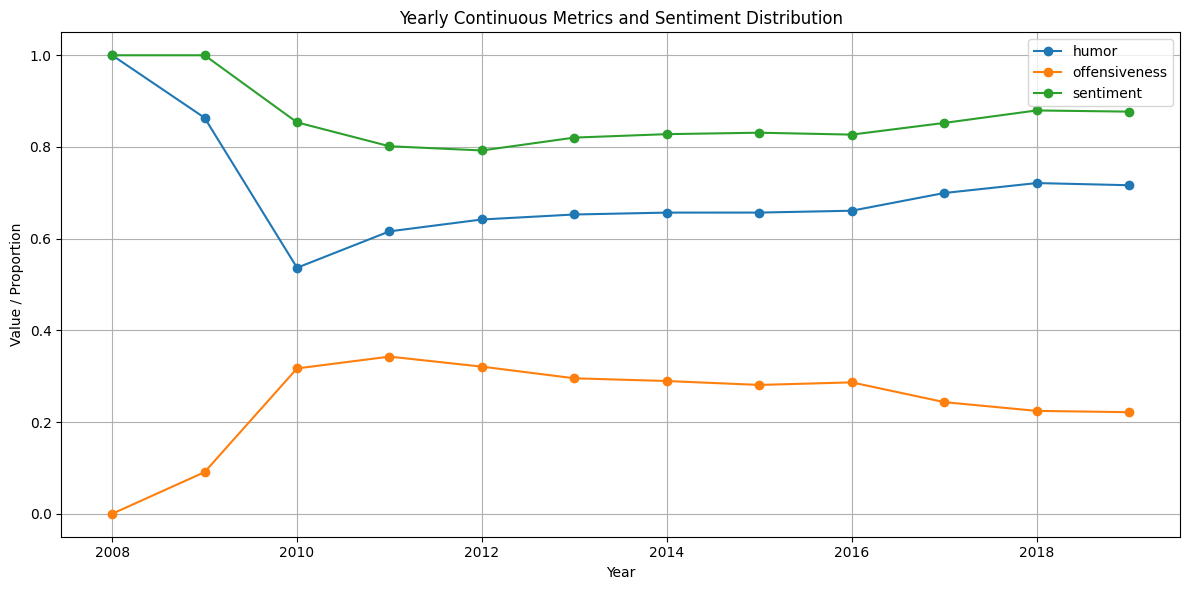

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure that the 'date' column is in datetime format and extract the year
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# ----- 1. Continuous Metrics: Humor and Offensiveness -----
continuous_cols = ['humor', 'offensiveness', 'sentiment']
yearly_avg = df.groupby('year')[continuous_cols].mean()

# ----- Combined Plot on a Single y-axis -----
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the continuous metrics
for metric in continuous_cols:
    ax.plot(yearly_avg.index, yearly_avg[metric], marker='o', label=metric)

ax.set_xlabel('Year')
ax.set_ylabel('Value / Proportion')
ax.set_title('Yearly Continuous Metrics and Sentiment Distribution')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


# world cloud visulization

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
# word cloud for funny jokes
funny_jokes = " ".join(df[df["humor"] == 1]["joke"].to_list())
# Generate a word cloud object
wc = WordCloud(width=800, height=400, background_color='white').generate(funny_jokes)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# word cloud for offensive jokes
off_jokes = " ".join(df[df["offensiveness"] == 1]["joke"].to_list())
# Generate a word cloud object
wc = WordCloud(width=800, height=400, background_color='white').generate(off_jokes)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# word cloud for positive jokes
pos_jokes = " ".join(df[df["sentiment"] == 1]["joke"].to_list())
# Generate a word cloud object
wc = WordCloud(width=800, height=400, background_color='white').generate(pos_jokes)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# word cloud for positive jokes
neg_jokes = " ".join(df[df["sentiment"] == 0]["joke"].to_list())
# Generate a word cloud object
wc = WordCloud(width=800, height=400, background_color='white').generate(neg_jokes)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# checking samples
df[df["humor"] == 1]["joke"].iloc[6]

In [ ]:
df[(df["offensiveness"] == 1) & (df["humor"] == 1)]["joke"].iloc[3]